In [1]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_pgm(filename, byteorder='>'):
    """
    Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    Source:
    http://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986#7369986
    
    Parameters
    ----------
    filename : str
        The path to the PGM file.
    byteorder : str
        The order of the bytes in the PGM file.

    Returns
    -------
    numpy.array
        The PGM file transformed into a 2D numpy array. The numpy array is
        an identical representation of the image stored in the PGM file.

    """
    with open(filename, 'rb') as f:
        buffer_ = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer_).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer_,
                         dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                         count=int(width)*int(height),
                         offset=len(header)
                         ).reshape((int(height), int(width)))

def create_data_frame(number_of_classes=40, number_of_images_per_classes=10, image_scaling_factor = 0.5):
    """
    Organise the data into a data frame.
    
    Parameters
    ----------
    number_of_subjects : int
        The number of different classes in the data.
    number_of_images_per_subject : int
        The number of members of different classes in the data (balanced data set, i.e.: same number of members per class)
    image_scaling_factor: float
        The caling factor by which the images are scaled to reduce the required computation during PCA and KNN training.
    
    Returns
    -------
    pandas.DataFrame
        The data frame of the organised data.
        The columns are: 
        subject, image, image_as_np_array, image_as_np_vector, image_resized, 
        image_resized_as_np_array, image_resized_as_np_vector

    """
    df = pd.DataFrame(data={"class":[], "image":[], "image_as_np_array":[], "image_as_np_vector":[], 
                            "image_resized":[], "image_resized_as_np_array":[], "image_resized_as_np_vector":[]})
    for number_of_class in range(1,number_of_classes+1):
        for number_of_image in range(1,number_of_images_per_classes+1):
            path = \
                os.path.join(os.path.abspath(''),"subjects",
                             "s"+str(number_of_class), str(number_of_image)+".pgm")
            image_as_np_array = read_pgm(filename=path)
            image_as_np_vector = image_as_np_array.flatten()
            image = Image.fromarray(image_as_np_array)
            image_resized = \
                image.resize((int(image_scaling_factor*image.size[0]), 
                              int(image_scaling_factor*image.size[1])), 
                             Image.NEAREST)
            image_resized_as_np_array = np.array(image_resized)
            image_resized_as_np_vector = image_resized_as_np_array.flatten()
            df = df.append({"class":int(number_of_class), 
                            "image":image, 
                            "image_as_np_array": image_as_np_array, 
                            "image_as_np_vector":image_as_np_vector,
                            "image_resized":image_resized, 
                            "image_resized_as_np_array":image_resized_as_np_array,
                            "image_resized_as_np_vector":image_resized_as_np_vector},
                            ignore_index=True)
    return df

def plot_gallery(images, titles, h, w, n_row, n_col):
    """
    Helper function to plot a gallery of portraits.
    Source:
    https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    """
    Helper function to plot gallery of portraits.
    Source:
    https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
    """
    pred_name = y_pred[i]
    true_name = y_test[i]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

Shape of an image=(112, 92)


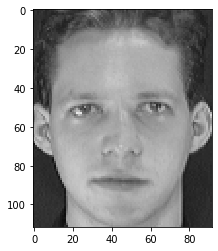

Shape of a resized image=(56, 46)


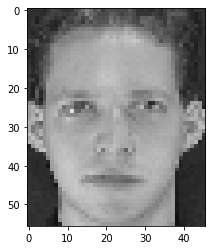

In [5]:
# Inspect data.
# Read an image.
probe_path = "./subjects/s1/1.pgm"
probe_image_as_np_array = read_pgm(filename=probe_path)
# Shape of an image.
print("Shape of an image={0}".format(probe_image_as_np_array.shape))
# Show an image.
plt.imshow(probe_image_as_np_array, cmap='gray', vmin=0, vmax=255)
plt.show()
#Show a resized image.
probe_image_as_image = Image.fromarray(probe_image_as_np_array)
probe_image_as_image_scaled = \
    probe_image_as_image.resize((int(probe_image_as_image.size[0]/2), 
                                 int(probe_image_as_image.size[1]/2)), Image.NEAREST)
print("Shape of a resized image={0}".format(np.array(probe_image_as_image_scaled).shape))
plt.imshow(probe_image_as_image_scaled, cmap='gray', vmin=0, vmax=255)
plt.show()

In [6]:
# Create data frame.
df = create_data_frame()

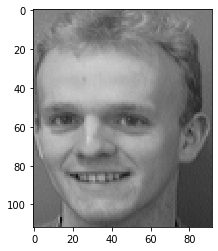

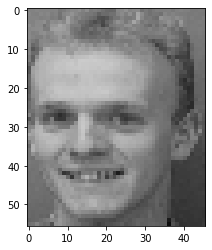

In [7]:
# Inspect the data frame.
subject_no = 5
picture_no = 0
test_pictures = df[df["class"]==subject_no]
image = test_pictures.iloc[picture_no]["image"]
image_resized = test_pictures.iloc[picture_no]["image_resized"]
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(image_resized, cmap='gray', vmin=0, vmax=255)
plt.show()

In [10]:
# Prepare independent and dependent variables as matrices.
X = np.vstack(df["image_resized_as_np_vector"])
Y = np.vstack(df["class"])
print("The shape of input data:{0}, the shape of output data:{1}".format(X.shape, Y.shape))

# Startified shuffle split of data. Ensure that the training and the testing data sets have the same
# amount of instances of each class (i.e.: balanced training data set and testing data set).
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=110)
train_indices, test_indices = list(sss.split(X,Y))[0]

X_train = X[train_indices]
Y_train = Y[train_indices]
X_test = X[test_indices]
Y_test = Y[test_indices]

print("Shapes are X_train:{0}, Y_train:{1}, X_test:{2}, Y_test:{3}".format(X_train.shape, Y_train.shape, 
                                                                           X_test.shape, Y_test.shape))

# Check if the training and the testing data are balanced data sets (i.e.: have the same number of occurences per class). 
Y_train_unique, Y_train_counts = np.unique(Y_train, return_counts=True)
Y_test_unique, Y_test_counts = np.unique(Y_test, return_counts=True)

Y_train_classes_and_occurences = dict(zip(Y_train_unique, Y_train_counts))
Y_test_classes_and_occurences = dict(zip(Y_test_unique, Y_test_counts))
print("The training and the testing data {0} have the same number of occurences in each class".format(
    "DO" if Y_train_classes_and_occurences == Y_test_classes_and_occurences else "DO NOT"))

The shape of input data:(400, 2576), the shape of output data:(400, 1)
Shapes are X_train:(200, 2576), Y_train:(200, 1), X_test:(200, 2576), Y_test:(200, 1)
The training and the testing data DO have the same number of occurences in each class


In [11]:
# Run PCA and KNN on normalized data.

# Normalize input data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
    
# Run PCA on non-normalized data.
n_components = 180
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
pca.fit(X_train)

# Extract the principal component loading vectors (i.e.: eigenfaces) on non-normalized data.
eigenfaces = pca.components_

# Transform data for KNN.
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Run KNN on non-normalized data.
n_neighbors = 1
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train_pca, Y_train.ravel())
Y_prediction = knn.predict(X_test_pca)

print('\nPrediction accuracy for test dataset with PCA (metrics)')
print('{:.2%}\n'.format(metrics.accuracy_score(Y_test, Y_prediction)))
print('\nPrediction accuracy for test dataset with PCA'.format(knn.score(X_test_pca, Y_test.ravel())))
print('{:.2%}\n'.format(knn.score(X_test_pca, Y_test.ravel())))


Prediction accuracy for test dataset with PCA (metrics)
93.00%


Prediction accuracy for test dataset with PCA
93.00%



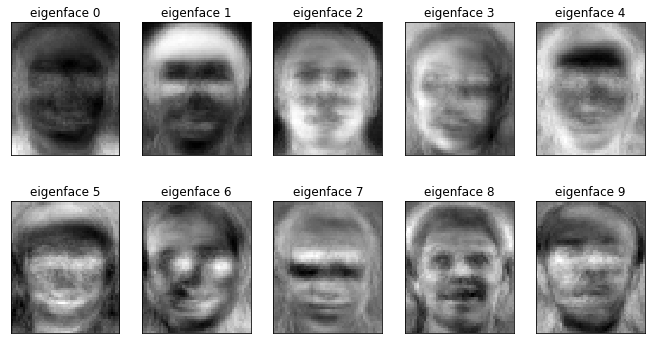

In [12]:
# Visualising eigenfaces.
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(images=eigenfaces, titles=eigenface_titles, h=56, w=46, n_row=2, n_col=5)

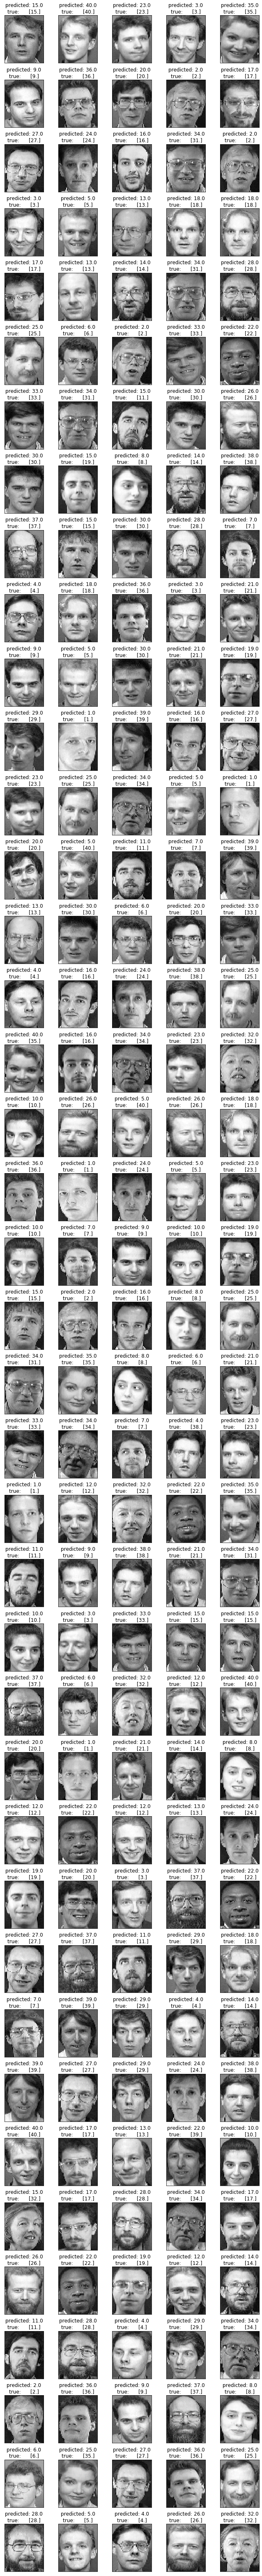

In [13]:
# Visualising predicitions.
target_names = range(1,41)
prediction_titles = [title(Y_prediction, Y_test, target_names, i) for i in range(Y_prediction.shape[0])]
plot_gallery(images=scaler.inverse_transform(X_test), titles=prediction_titles, h=56, w=46, n_row=40, n_col=5)

In [14]:
# The eigenvalues/principal component loading vectors/eignefaces of X_train are the columns of eigenfaces.
# The corrsponding eignevalues of the eigenvectors are the values of the explained variance in X_train by each eigenvector.
# The greater the explained variance (eigenvalue) of an eigenvector, the better it captures 
# some portion of the variance in X_train.
# Decomposing the covariance matrix into V and D where V is the eigenvector matrix and D is the eigenvalues diagonal matrix.

# The explained variance ratio by the eigenvectors of X are shown below with two approach.
cov_matrix = np.cov(X_train.T)/X_train.shape[1]
for eigenvector, idx in zip(eigenfaces, range(10)):
    print("The no.{0} eigenface explains {1}% of the variance in X_train.".format(
        idx, np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))))
print("\n")

# Simpler method, same thing.
for idx, variance_explained in enumerate(pca.explained_variance_ratio_[:10]):
    print("The no.{0} eigenface explains {1}% of the variance in X_train.".format(idx, variance_explained))

# The "weigths" of each eigenvectro on the 2576 features (in this case pixels) are shown below.
print(abs(pca.components_).shape)
for eigenface_idx, weights_of_eigenface in enumerate(abs( pca.components_ )):
    max_weight_idx = np.argmax(weights_of_eigenface)
    max_weight = np.max(weights_of_eigenface)
    print("The no.{0} eigenvector's biggest weight is {1} and it's on feature no.{2}".format(
        eigenface_idx, max_weight, max_weight_idx))

The no.0 eigenface explains 0.16267918060802478% of the variance in X_train.
The no.1 eigenface explains 0.12722584941525755% of the variance in X_train.
The no.2 eigenface explains 0.08279976332409521% of the variance in X_train.
The no.3 eigenface explains 0.057785677411334925% of the variance in X_train.
The no.4 eigenface explains 0.050448016992367166% of the variance in X_train.
The no.5 eigenface explains 0.028551425946662996% of the variance in X_train.
The no.6 eigenface explains 0.025838533054657834% of the variance in X_train.
The no.7 eigenface explains 0.02397118716203764% of the variance in X_train.
The no.8 eigenface explains 0.02092177633775133% of the variance in X_train.
The no.9 eigenface explains 0.020158079379038484% of the variance in X_train.


The no.0 eigenface explains 0.1618657847049845% of the variance in X_train.
The no.1 eigenface explains 0.12658972016818132% of the variance in X_train.
The no.2 eigenface explains 0.08238576450747458% of the variance in X_

In [15]:
# Final notes: 
# (1): normalization reduces accuracy by approx. 1%, (2) PCA does not improve KNN accuracy
# Resources used:
# (1) https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# (2) https://www.mathworks.com/help/matlab/ref/eig.html
# (3) https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
# (4) https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
# (5) https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
# (6) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# (7) https://en.wikipedia.org/wiki/Eigenface
# (8) https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score
# (9) https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
# (10) https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
